## Predicting Employee Attrition using Probabilistic Models

In this notebook, we explore the problem of employee attrition prediction using a dataset containing demographic, job, and performance-related variables. The goal is to identify which employees are at risk of leaving the company.

We approach this task using a Bayesian Probabilistic Principal Component Analysis (PPCA) model combined with Bayesian Logistic Regression, implemented in Pyro. This allows us to:
- Perform dimensionality reduction in a principled way.
- Incorporate uncertainty in both features and predictions.
- Analyze the influence of latent components and predictors on attrition risk.

This notebook includes:
- Data preprocessing and transformation
- PPCA + Bayesian Logistic Regression modeling
- Model training and evaluation
- Visual analysis of model performance and confusion matrix

In [15]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam
from pyro.contrib.autoguide import AutoNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import itertools

### 1. Load and process data

Load the dataset and preprocess it by encoding categorical variables and standardizing numerical features. This ensures the data is in a clean and consistent format, ready for modeling.

In [8]:
# Load the data set
data = pd.read_csv('data/dataset.csv')

# Binary mapping
binary_map = {
    "Attrition": {"No": 0, "Yes": 1},
    "Gender": {"Male": 0, "Female": 1},
    "OverTime": {"No": 0, "Yes": 1},
    "Over18": {"N": 0, "Y": 1}
}

# Converting all binary columns
for col, mapping in binary_map.items():
    if col in data.columns:
        data[col] = data[col].map(mapping)

# One-hot encoding for multi-class categorical columns
categorical_cols = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
data = pd.get_dummies(data, columns=categorical_cols)

# Convert all boolean dummies to integers
data = data.astype({col: int for col in data.select_dtypes(include='bool').columns})

# Basic summary statistics
print(data.describe())

               Age    Attrition    DailyRate  DistanceFromHome    Education  \
count  1470.000000  1470.000000  1470.000000       1470.000000  1470.000000   
mean     36.923810     0.161224   802.485714          9.192517     2.912925   
std       9.135373     0.367863   403.509100          8.106864     1.024165   
min      18.000000     0.000000   102.000000          1.000000     1.000000   
25%      30.000000     0.000000   465.000000          2.000000     2.000000   
50%      36.000000     0.000000   802.000000          7.000000     3.000000   
75%      43.000000     0.000000  1157.000000         14.000000     4.000000   
max      60.000000     1.000000  1499.000000         29.000000     5.000000   

       EmployeeCount  EmployeeNumber  EnvironmentSatisfaction       Gender  \
count         1470.0     1470.000000              1470.000000  1470.000000   
mean             1.0     1024.865306                 2.721769     0.400000   
std              0.0      602.024335                 1

#### Correlation

In [9]:
# Find all features with high correlation (0.7 threshold)
def get_high_correlation_features(data, threshold=0.7):
    corr = data.corr()
    high_corr_var = np.where(corr > threshold)
    high_corr_var = [(corr.columns[x], corr.columns[y], corr.iloc[x, y])
                     for x, y in zip(*high_corr_var)
                     if x != y and x < y]
    return high_corr_var

high_corr_features = get_high_correlation_features(data, threshold=0.7)

# Print list of features with more than 70% correlation
print("Features with correlation greater than 0.7:")
for f1, f2, value in high_corr_features:
    print(f"{f1} - {f2}: {value:.2f}")

Features with correlation greater than 0.7:
JobLevel - MonthlyIncome: 0.95
JobLevel - TotalWorkingYears: 0.78
MonthlyIncome - TotalWorkingYears: 0.77
PercentSalaryHike - PerformanceRating: 0.77
YearsAtCompany - YearsInCurrentRole: 0.76
YearsAtCompany - YearsWithCurrManager: 0.77
YearsInCurrentRole - YearsWithCurrManager: 0.71
Department_Human Resources - JobRole_Human Resources: 0.90
Department_Sales - JobRole_Sales Executive: 0.81


Now when features with high pairwise correlation (greater than 0.7) has been identified, one
feature from each correlated pair is removed to mitigate multicollinearity. Multicollinearity can distort
the importance of individual predictors and lead to unstable estimates in downstream models.

In [10]:
# Delete variables with high correlation 
data = data.drop(columns=[
    "MonthlyIncome",
    "TotalWorkingYears",
    "PerformanceRating",
    "YearsInCurrentRole",
    "YearsWithCurrManager",
    "Department_Human Resources",
    "Department_Sales"
])

#### Distribution of the target variable

Before building and evaluating predictive models, it is crucial to examine the distribution of the target variable,  in our case, Attrition. This step helps reveal whether the dataset is balanced or imbalanced, which significantly impacts both model performance and evaluation.

In [11]:
data["Attrition"].value_counts(normalize=True)

Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64

The output shows that the dataset is highly imbalanced: ~84% of employees did not leave (Attrition = 0), while only ~16% did (Attrition = 1). This imbalance should be addressed when training models, as it can bias predictions toward the majority class and result in misleading accuracy scores.

### 2. Probabilistic PCA for Dimensionality Reduction

In this section, we use Probabilistic Principal Component Analysis (PPCA) to reduce the dimensionality of our standardized feature space. Unlike traditional PCA, PPCA is a generative probabilistic model that allows us to model uncertainty in the latent space and easily integrate with Bayesian models.

We:
- Normalize the feature matrix for stability and interpretability.
- Define a Bayesian PPCA model using Pyro.
- Fit the model using Stochastic Variational Inference (SVI).
- Compare models across different latent dimensions by evaluating the Evidence Lower Bound (ELBO).
- Select the latent dimension that yields the best model fit.
- Extract the latent variables (z) which capture the underlying structure of the data, and combine them with the original target (Attrition) for downstream modeling.

This latent representation will be the basis for our Bayesian Logistic Regression model later.

In [12]:
np.random.seed(42)

# Drop column we are predicting "Attrition"
target = data["Attrition"]
data = data.drop(columns=["Attrition"])

# Standardize
X_np = data.to_numpy()
X_mean = np.nanmean(X_np, axis=0)
X_std = np.nanstd(X_np, axis=0)

# Avoid division by zero
X_std[X_std == 0] = 1.0

X = (X_np - X_mean) / X_std
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X = torch.tensor(X, dtype=torch.float32)

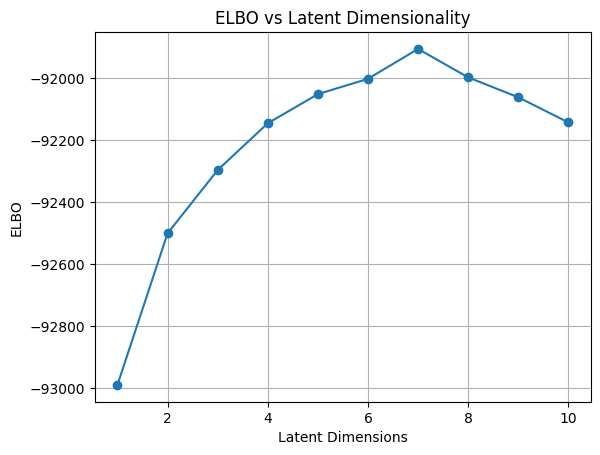

Best latent dimension selected: 7


In [13]:
# Define PPCA model
def ppca_model(X, latent_dim):
    N, D = X.shape
    W = pyro.sample("W", dist.Normal(0, 1).expand([D, latent_dim]).to_event(2))
    sigma  = pyro.sample("sigma",  dist.HalfCauchy(1)) 
    
    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))
        loc = torch.matmul(z, W.T)
        pyro.sample("obs", dist.Normal(loc, sigma).to_event(1), obs=X)

# Search for best latent dimension
best_latent_dim = None
best_elbo = float('-inf')
best_z_loc = None

elbos = []
dims = list(range(1, 11))  # Dimensions from 1 to 10

# Loop over possible latent dimensions to find the best one
for latent_dim in dims:
    pyro.clear_param_store()
    
    # Define a model wrapper with the current latent dimension
    def model_wrapped(X):
        return ppca_model(X, latent_dim)

    # Use AutoNormal as the variational guide for inference
    guide = AutoNormal(model_wrapped)

    # Set up optimizer and SVI (Stochastic Variational Inference)
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model_wrapped, guide, optimizer, loss=Trace_ELBO())
    
    # Run variational inference for a fixed number of steps
    num_steps = 1000
    final_loss = None
    for step in range(num_steps):
        loss = svi.step(X)
        final_loss = loss

    # Compute the Evidence Lower Bound (ELBO) as negative loss
    elbo = -final_loss
    elbos.append(elbo)

    # Update best model if current ELBO is the highest so far
    if elbo > best_elbo:
        best_elbo = elbo
        best_latent_dim = latent_dim
        best_z_loc = guide(X)["z"].detach().numpy()

# Plot ELBO vs latent dimensions
plt.plot(dims, elbos, marker='o')
plt.xlabel('Latent Dimensions')
plt.ylabel('ELBO')
plt.title('ELBO vs Latent Dimensionality')
plt.grid(True)
plt.show()

print(f"Best latent dimension selected: {best_latent_dim}")

# Merge with target
reduced_df = pd.DataFrame(best_z_loc, columns=[f"z{i+1}" for i in range(best_latent_dim)])
reduced_df["Attrition"] = target.values

The plot shows the ELBO for different latent dimensionalities. Since higher ELBO values indicate better model fit, the optimal dimensionality is where ELBO peaks. In this case, a latent dimension of 7 provides the best trade-off between model complexity and fit to the data.

### 3. Binary Logistic Regression with Latent Features

In this section, we use the latent representations from PPCA to train a Bayesian Binary Logistic Regression (BLR) model that predicts employee attrition.

Key steps include:
- Splitting the latent feature matrix and binary attrition labels into training and test sets.
- Defining a probabilistic logistic regression model using Pyro, with priors on the weights (β) and the intercept.
- Training the model using Stochastic Variational Inference (SVI) and evaluating with the Evidence Lower Bound (ELBO).
- Generating predictions on the test set and evaluating performance via accuracy and confusion matrix.
- Visualizing the prior predictive distribution of attrition probability to assess uncertainty before training.

In [16]:
np.random.seed(42)

# Set up a color palette
palette = itertools.cycle(sns.color_palette())

# Extract input features (z1–z7) and target variable from the reduced dataset
X = reduced_df.iloc[:, :7].values
y = reduced_df.iloc[:, 7].astype(int).values
ind = y.copy()

# Split data into training and test sets (66% train, 34% test)
train_perc = 0.66 
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # We also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]

# Apply split to data
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]

# Print final split counts
print("Num train: %d" % len(y_train))
print("Num test: %d" % len(y_test))

# Compute class balance and convert it to log-odds for intercept prior
epsilon = 1e-6
p = y_train.mean().item()
p = np.clip(p, epsilon, 1 - epsilon)
log_odds = np.log(p / (1 - p))

Num train: 970
Num test: 500


[Step 0] ELBO: 709.68
[Step 1000] ELBO: 463.01
[Step 2000] ELBO: 419.86
[Step 3000] ELBO: 419.49
[Step 4000] ELBO: 419.27
[Step 5000] ELBO: 419.66
[Step 6000] ELBO: 419.76
[Step 7000] ELBO: 420.07
[Step 8000] ELBO: 419.54
[Step 9000] ELBO: 420.13
[Step 10000] ELBO: 419.60
[Step 11000] ELBO: 419.80
[Step 12000] ELBO: 418.94
[Step 13000] ELBO: 420.09
[Step 14000] ELBO: 419.60
[Step 15000] ELBO: 418.84
[Step 16000] ELBO: 419.60
[Step 17000] ELBO: 419.87
[Step 18000] ELBO: 419.70
[Step 19000] ELBO: 420.05
[Step 20000] ELBO: 419.56
[Step 21000] ELBO: 419.57
[Step 22000] ELBO: 419.27
[Step 23000] ELBO: 419.71
[Step 24000] ELBO: 418.97
[Step 25000] ELBO: 418.95
[Step 26000] ELBO: 419.47
[Step 27000] ELBO: 419.42
[Step 28000] ELBO: 420.01
[Step 29000] ELBO: 419.64
[Step 30000] ELBO: 419.64
[Step 31000] ELBO: 419.72
[Step 32000] ELBO: 419.87
[Step 33000] ELBO: 419.74
[Step 34000] ELBO: 419.19
[Step 35000] ELBO: 419.85
[Step 36000] ELBO: 420.82
[Step 37000] ELBO: 419.44
[Step 38000] ELBO: 421.15

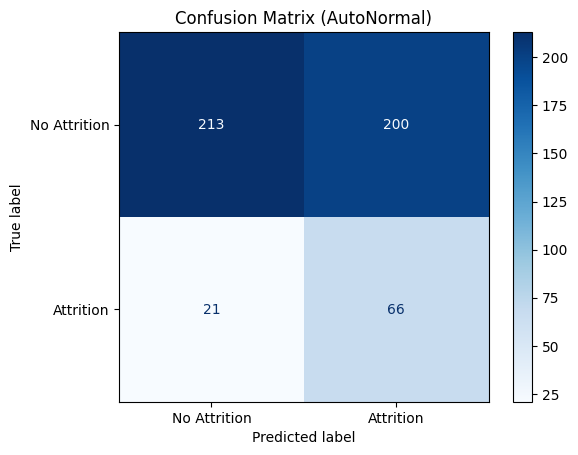

In [17]:
# Define the BLR model
def model(X, n_cat, y=None):
    n_features = X.shape[1]

    # Prior for beta coefficients 
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([n_features, 1]).to_event(2)) 

    # Prior for intercept guided by class balance
    intercept = pyro.sample("intercept", dist.Normal(log_odds, 1.0))

    # Linear predictor (logits), input features to the bernouli
    logits = X @ beta + intercept  

    # Define likelihood over observed labels using a Bernoulli distribution
    with pyro.plate("data", X.shape[0]):
        y = pyro.sample("y", dist.Bernoulli(logits=logits.squeeze(-1)), obs=y)
    
    return y

# Convert training and test sets to PyTorch tensors (float32 for X, bool for y)
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).bool()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).bool()

# Clear previous state
pyro.clear_param_store()

# Use AutoNormal guide for variational inference (mean-field approximation)
guide = AutoNormal(model)

# Define optimizer and ELBO objective for training
optimizer = ClippedAdam({"lr": 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

# Training loop using Stochastic Variational Inference
n_steps = 40000
for step in range(n_steps):
    loss = svi.step(X_train, n_cat=None, y=y_train.float())
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

# Draw 1000 posterior samples to estimate beta coefficients on test data
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("beta",))
samples = predictive(X_test, n_cat=None, y=None)  

# Extract and reshape beta samples
beta_samples = samples["beta"].detach().squeeze()  

# Average over posterior beta samples to obtain mean coefficients
beta_mean = beta_samples.mean(0)  

# Compute test set logits and apply sigmoid to get predicted probabilities
logits_test = X_test @ beta_mean
probs_test = torch.sigmoid(logits_test)

# Predict labels using 0.5 threshold
y_pred = (probs_test > 0.5).int()

# Compute test accuracy
accuracy = (y_pred == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy:.3f}")

# Plot confusion matrix
cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attrition", "Attrition"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (AutoNormal)")
plt.show()

The confusion matrix shows that the model correctly identifies many of the “Attrition” cases (66 out of 87), which is encouraging given the class imbalance. However, it misclassifies a large number of “No Attrition” cases as “Attrition” (200 false positives), leading to a relatively low overall accuracy of 55.8%. While this suggests the model captures the minority class well, it does so at the cost of precision for the majority class.

### 4. Combined Probabilistic PCA and Binary Logistic Regression

In this section, we build a joint probabilistic model that combines Probabilistic PCA (PPCA) with Bayesian Logistic Regression (BLR) to predict employee attrition.

Key ideas:
- PPCA reduces the high-dimensional feature space into a lower-dimensional latent space while modeling uncertainty in the feature reconstruction.
- Logistic Regression is applied in the latent space to model the probability of attrition.
- By modeling both parts jointly, we allow uncertainty in feature compression to propagate into the classification, resulting in a more robust model.
- We also incorporate class imbalance using manually computed weights in the Bernoulli likelihood, which helps compensate for the skewed distribution between attrition and non-attrition.

This combined model is trained using Stochastic Variational Inference (SVI) in Pyro and evaluated on a test set using accuracy, a confusion matrix, and a classification report that includes precision, recall, and F1-score for both classes.

X_train shape: torch.Size([970, 46]), y_train shape: torch.Size([970])
[Step 0] ELBO: 262400.19
[Step 1000] ELBO: 63979.40
[Step 2000] ELBO: 63294.52
[Step 3000] ELBO: 63012.81
[Step 4000] ELBO: 62919.93
[Step 5000] ELBO: 62905.04
[Step 6000] ELBO: 62827.09
[Step 7000] ELBO: 62725.30
[Step 8000] ELBO: 62686.23
[Step 9000] ELBO: 62581.13
[Step 10000] ELBO: 62512.36
[Step 11000] ELBO: 62473.89
[Step 12000] ELBO: 62460.78
[Step 13000] ELBO: 62476.34
[Step 14000] ELBO: 62476.93
[Step 15000] ELBO: 62540.18
[Step 16000] ELBO: 62452.56
[Step 17000] ELBO: 62414.31
[Step 18000] ELBO: 62425.26
[Step 19000] ELBO: 62449.45
[Step 20000] ELBO: 62432.59
[Step 21000] ELBO: 62448.98
[Step 22000] ELBO: 62428.92
[Step 23000] ELBO: 62434.86
[Step 24000] ELBO: 62353.53
[Step 25000] ELBO: 62820.40
[Step 26000] ELBO: 62434.07
[Step 27000] ELBO: 62427.19
[Step 28000] ELBO: 62436.14
[Step 29000] ELBO: 62426.56
[Step 30000] ELBO: 62405.31
[Step 31000] ELBO: 62471.38
[Step 32000] ELBO: 62470.82
[Step 33000] ELBO

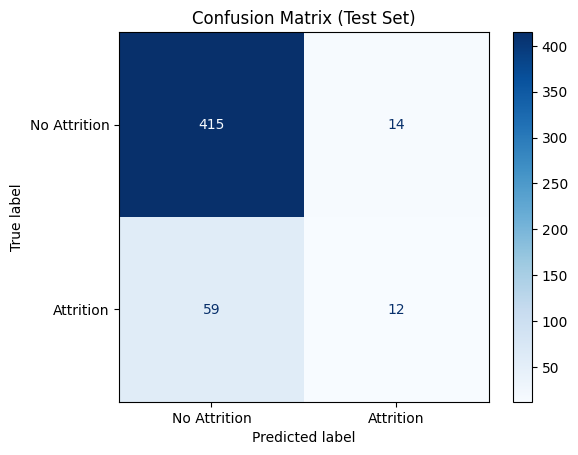

In [135]:
np.random.seed(42)

# Standardize 
X_np = data.to_numpy()
X_mean = np.nanmean(X_np, axis=0)
X_std = np.nanstd(X_np, axis=0)
X_std[X_std == 0] = 1.0
X_np = (X_np - X_mean) / X_std
X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

# Split the data
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, target, train_size=0.66, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np.to_numpy(), dtype=torch.float32)

# Define dimensions
_, D = X_train.shape
latent_dim = 7  # Known from running PPCA seperately

# Hyperparameters for priors
degF = 1
tau = 3

# Define the combined PPCA + BLR model
def combined_ppca_blr_model(X, y=None):
    N, D = X.shape
    
    # Priors for PPCA weight matrix W
    mu_W = pyro.sample("mu_W", dist.Normal(0, 1).expand([D, latent_dim]).to_event(2))
    sigma_W = pyro.sample("sigma_W", dist.HalfCauchy(scale=1.0).expand([D, latent_dim]).to_event(2))
    W = pyro.sample("W", dist.Normal(mu_W, sigma_W).to_event(2))

    # Prior for observation noise sigma
    scale_sigma = pyro.sample("scale_sigma", dist.HalfCauchy(1.0))
    sigma = pyro.sample("sigma", dist.HalfCauchy(scale=scale_sigma))
    
    # Priors for logistic regression parameters
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=degF,
    loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim)).to_event(1))
    sigma_beta = pyro.sample("sigma_beta",dist.HalfCauchy(scale=tau * torch.ones(latent_dim)).to_event(1))
    beta = pyro.sample("beta", dist.Normal(loc=mu_beta, scale=sigma_beta).to_event(1)) 
    
    # Prior for intercept
    intercept = pyro.sample("intercept", dist.Normal(0., 1.))
    
    with pyro.plate("data", N):

        # Latent variable z
        z = pyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))
        
        # Generate X through PPCA
        loc = torch.matmul(z, W.mT)
        pyro.sample("obs_X", dist.Normal(loc, sigma).to_event(1), obs=X)
        
        # Generate y
        logits = (z * beta).sum(-1) + intercept

        # Compute inverse class weights for imbalance handling
        w1 = (y == 0).sum() / y.shape[0]  
        w0 = (y == 1).sum() / y.shape[0]
        weights = torch.where(y == 1, w1, w0)

        # Weighted log-probability
        log_prob = dist.Bernoulli(logits=logits).log_prob(y)
        pyro.factor("weighted_loss", (weights * log_prob).sum())

# Function to compute latent encodings z from X using the learned PPCA parameters
def ppca_encoder(X, W, sigma):
    D, latent_dim = W.shape
    N = X.shape[0]
    WtW = W.T @ W
    cov_z_inv = WtW + sigma**2 * torch.eye(latent_dim)
    cov_z = torch.inverse(cov_z_inv)
    z_mean = (cov_z @ W.T @ X.T).T
    return z_mean

# Inference setup
pyro.clear_param_store()
guide = AutoNormal(combined_ppca_blr_model)
optimizer = Adam({"lr": 0.01})
svi = SVI(combined_ppca_blr_model, guide, optimizer, loss=Trace_ELBO())

# Train the model
num_steps = 40000
for step in range(num_steps):
    loss = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

# Extract posterior mean estimates
posterior_samples = guide(X_train, y_train)
W_mean = posterior_samples['W']
sigma_mean = posterior_samples['sigma']
beta_mean = posterior_samples['beta']
intercept_mean = posterior_samples['intercept']

# Encode test data using PPCA
z_test_encoded = ppca_encoder(X_test, W_mean, sigma_mean)

# Predict attrition on test set
logits_test = (z_test_encoded * beta_mean).sum(-1) + intercept_mean
probs_test = torch.sigmoid(logits_test)
y_pred_test = (probs_test > 0.5).int()

# Accuracy on test set
accuracy_test = (y_pred_test == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy_test:.3f}")

# Plot confusion matrix
cm = confusion_matrix(y_test.numpy(), y_pred_test.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attrition", "Attrition"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [138]:
# More performance evaluation metrics
print(classification_report(y_test.numpy(), y_pred_test.numpy(), target_names=["No Attrition", "Attrition"]))

              precision    recall  f1-score   support

No Attrition       0.88      0.97      0.92       429
   Attrition       0.46      0.17      0.25        71

    accuracy                           0.85       500
   macro avg       0.67      0.57      0.58       500
weighted avg       0.82      0.85      0.82       500



The model achieves high overall accuracy (85.4%), mainly due to strong performance on the majority class (No Attrition). It predicts these cases with high precision (0.88) and recall (0.97). However, it struggles with the minority class (Attrition), correctly identifying only 17% of true cases (recall: 0.17, precision: 0.46, f1-score: 0.25). This imbalance suggests that further improvements, such as resampling, adjusting thresholds, or enhancing feature selection, are needed to better capture attrition cases.

### 5. Conclusion

The combined Probabilistic PCA and Binary Logistic Regression model demonstrates high overall accuracy (85%) in predicting employee attrition. However, a closer look at the classification metrics reveals a strong imbalance in predictive performance across classes:
- No Attrition: High precision (0.88), recall (0.97), and F1-score (0.92) indicate the model performs very well for the majority class.
- Attrition: Despite improved class weighting, recall remains low (0.17) and the F1-score is only 0.25, meaning the model still misses most true attrition cases.

The confusion matrix confirms this: while 415 of 429 “No Attrition” cases are correctly identified, only 12 of 71 “Attrition” cases are detected.

This indicates the model is still biased toward the majority class, which is typical in imbalanced classification problems. Additional improvements could include:
- Further adjusting class weights,
- Incorporating resampling techniques (e.g., SMOTE),
- Exploring more expressive latent representations,
- Or using alternative models better suited for imbalanced data (e.g., ensemble methods or cost-sensitive learning).

In summary, while the combined model captures latent structure and predicts the majority class accurately, it struggles with minority class recall, limiting its practical usefulness in attrition detection where identifying potential leavers is critical.